In [2]:
import sys
sys.path.append('/home/kyriazis/projects/redner')
sys.path.append('/home/kyriazis/projects/redner/build')

In [66]:
import pyredner
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from imageio import imread

In [4]:
pyredner.set_use_gpu(True)
pyredner.render_pytorch.print_timing = False

In [5]:
material_map, mesh_list, light_map = pyredner.load_obj('/home/kyriazis/Crate/Crate1.obj')

In [29]:
cam = pyredner.Camera(position = torch.tensor([2., 2, 5]),
                      look_at = torch.tensor([0.0, 0.0, 0.0]),
                      up = torch.tensor([0.0, 1.0, 0.0]),
                      fov = torch.tensor([45.0]), # in degree
                      clip_near = 1e-2, # needs to > 0
                      resolution = (256, 256),
                      fisheye = False)

In [30]:
material_id_map = {}
materials = []
count = 0
for key, value in material_map.items():
    material_id_map[key] = count
    count += 1
    materials.append(value)

In [31]:
shapes = []
for mtl_name, mesh in mesh_list:
    assert(mesh.normal_indices is None)
    shapes.append(pyredner.Shape(\
        vertices = mesh.vertices,
        indices = mesh.indices,
        material_id = material_id_map[mtl_name],
        uvs = mesh.uvs,
        uv_indices = mesh.uv_indices))

In [32]:
envmap = pyredner.imread('tutorials/sunsky.exr')
if pyredner.get_use_gpu():
    envmap = envmap.cuda()
envmap = pyredner.EnvironmentMap(3 * envmap)

In [33]:
scene = pyredner.Scene(cam, shapes, materials, area_lights = [], envmap = envmap)

In [34]:
scene_args = pyredner.RenderFunction.serialize_scene(
    scene = scene,
    num_samples = 512,
    max_bounces = 1)
img = pyredner.RenderFunction.apply(1, *scene_args)

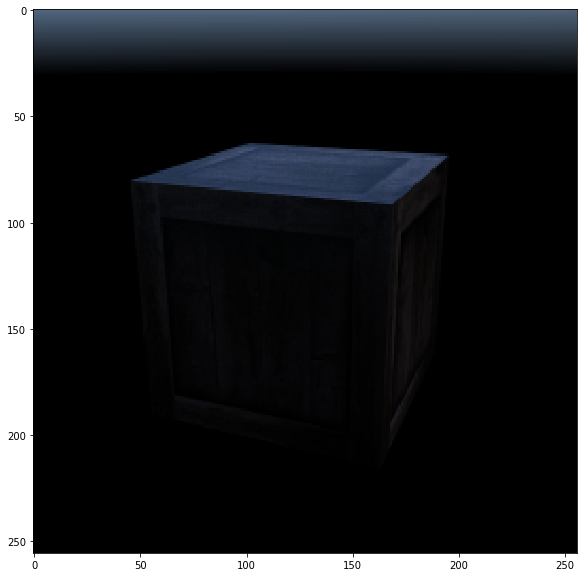

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(img.cpu())

In [37]:
def model(x):
    materials[0].diffuse_reflectance = pyredner.Texture(x)
    scene_args = pyredner.RenderFunction.serialize_scene(
        scene = scene,
        num_samples = 512,
        max_bounces = 1)
    return pyredner.RenderFunction.apply(1, *scene_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


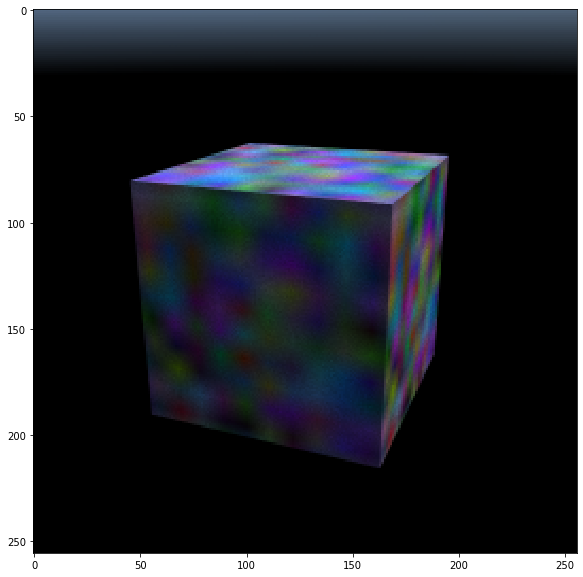

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(model(torch.rand(10,10,3).cuda()).cpu())

In [56]:
colors = torch.rand(32, 32, 3).cuda().requires_grad_(True)

In [59]:
optimizer = optim.Adam([colors], lr=0.1)

In [60]:
for iteration in range(100):
    optimizer.zero_grad()
    loss = (model(colors) - img).pow(2).mean()
    loss.backward()
    optimizer.step()
    print('{}/{} loss = {}'.format(iteration, 100, loss.item()))

0/100 loss = 0.003707126248627901
1/100 loss = 0.0012222122168168426
2/100 loss = 0.0005791479488834739
3/100 loss = 0.0005007651052437723
4/100 loss = 0.0005586858605965972
5/100 loss = 0.0006106594810262322
6/100 loss = 0.0006018755375407636
7/100 loss = 0.0005513801006600261
8/100 loss = 0.0004792840627487749
9/100 loss = 0.00040413159877061844
10/100 loss = 0.00033478622208349407
11/100 loss = 0.0002820235094986856
12/100 loss = 0.00024620804470032454
13/100 loss = 0.00021598458988592029
14/100 loss = 0.00019598915241658688
15/100 loss = 0.0001818587043089792
16/100 loss = 0.00016978222993202507
17/100 loss = 0.00016094233433250338
18/100 loss = 0.00015334876661654562
19/100 loss = 0.00014138975529931486
20/100 loss = 0.00012851755309384316
21/100 loss = 0.00011522965360200033
22/100 loss = 0.00010213165660388768
23/100 loss = 9.068245708476752e-05
24/100 loss = 8.039215026656166e-05
25/100 loss = 7.21808901289478e-05
26/100 loss = 6.535086868098006e-05
27/100 loss = 5.918319948250

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


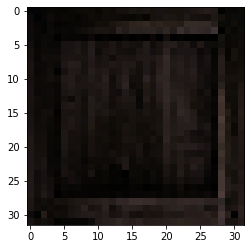

In [61]:
plt.imshow(colors.cpu().detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


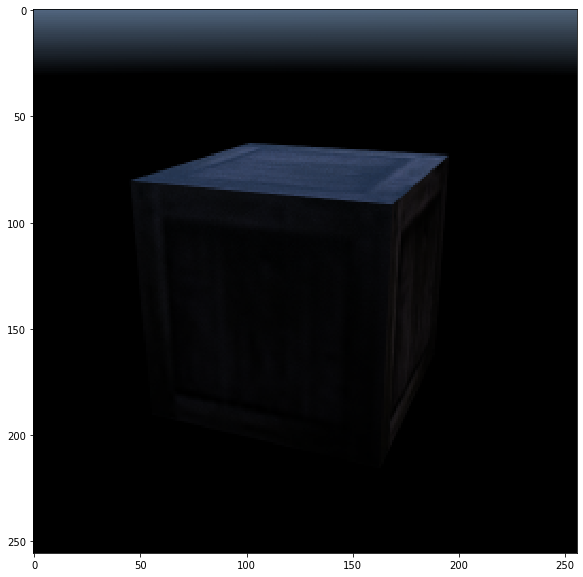

In [77]:
plt.figure(figsize=(10,10))
res = model(colors)
plt.imshow(res.cpu().detach())

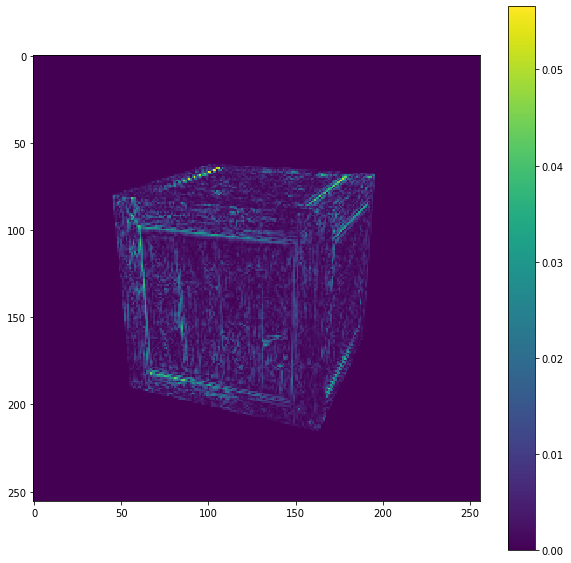

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(torch.sqrt((img - res).pow(2).sum(dim=-1)).cpu().detach())
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


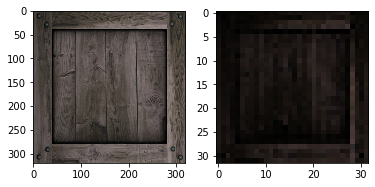

In [88]:
plt.subplot(1,2,1)
plt.imshow(imread('/home/kyriazis/Crate/crate_1.jpg'))
plt.subplot(1,2,2)
plt.imshow(colors.cpu().detach())